# Assignment 4
*By Ryan Cox*

In [2]:
using LinearAlgebra
using Plots
using LaTeXStrings
using MAT

## Q1

In [ ]:
"""
Structure for storing results of the tomography fitting.
"""
struct SVDAnalysis
     G::Matrix
     d::Vector # Observed
     dStd::Real
     m::Vector # Estimated
     covM::Matrix
     fig::Any # plot
     p::Integer
end


"""
Use singular value decomposition to solve an inverse problem described by G.
Based on TomographyFit() written for Assignment 3.

Parameters
        G::Matrix - Model kernel
        dObs::Vector - Observed data
        dStd::Real - Standard deviation of data
        p::Integer - Number of singular values considered

Returns as SVDAnalysis
"""
function SVDFit(G::Matrix, dObs::Vector, dStd::Real, p::Integer=-1)::SVDAnalysis
    # Decompose kernel G into U, S and V such that G = U * Diagonal(S) * Vt
    decomposition = svd(G)
    U = decomposition.U
    S = decomposition.S # The book calls it L. It is provided here already as a vector of the singular values.
    V = decomposition.V
    Vt = decomposition.Vt # transpose of V

    p = p < 0 ? length(S) : p # Use length(S) for p unless p specifically set in function call
    Sp = S[1:p] # Truncate component matrices
    Up = U[:,1:p]
    Vp = V[:,1:p]

    # Estimate parameters, their covariance
    mEst = Vp * ((transpose(Up) * dObs) ./ Sp)
    covM = dStd^2 * Vp * (Diagonal(Sp)^(-2)) * transpose(Vp)

    # prepare plots
    fig = plot(dObs, seriestype=:scatter, yerror=dStd, markerstrokecolor=:auto, label="Observed data", xlabel="index", ylabel="time (s)", title=label)
    fig = plot!(G * mEst, label="Predicted data")

    SVFAnalysis(G, dObs, dStd, mEst, covM, fig, p)
end

First let us load our data. We'll then plot all the seismograms together, just to demonstrate their similarity. This graph is useless for anything else, although it has a certain asthetic appeal.

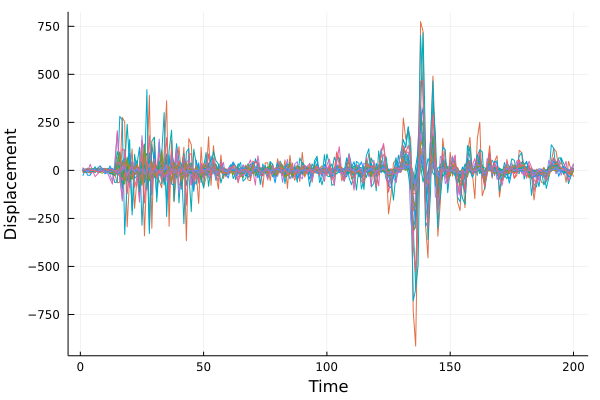

In [41]:
seismograms = matread("C:\\Users\\Ryan's PC\\github\\math322-inverse-theory\\seismograms.mat.mat")["seismograms"]
# I assume the format of the data is that each row is single seismogram.
# Each value is a displacement  and they are ordered chronoloigcally over some timescale?

"""
Plots the seismogram matrix such that all the seismograms are overlaid.
"""
function plotSeismogramMatrix(S::Matrix)::Plots.Plot
    # Setup a variable to store the plots
    p = plot(legend=false, xlabel="Time", ylabel="Displacement") # I don't know what the units are
    # Loop over all the seismograms
    for row in 1:size(S)[1]
        p = plot!(S[row,:])
    end
    return p
end

plotSeismogramMatrix(seismograms)

Now we will perform singular value decomposition on the data

In [48]:
"""
Display approximated seismograms.
"""
function ApproximateSeismograms(S::Matrix)::Plots.Plot
    # First perform svd decomposition
    decomposition = svd(seismograms)
    U = decomposition.U
    S = decomposition.S # The book calls it L. It is provided here already as a vector of the singular values.
    V = decomposition.V
    Vt = decomposition.Vt # transpose of V
    
    # Store matrices generated by p values
    # Indice of value = indice of p value used to generate it
    approximatedMatrices = Vector{Matrix}(undef, length(S))

    for p in 1:length(S)
        Up = U[:,1:p]
        Sp = S[1:p] # Truncate component matrices
        Vtp = Vt[1:p,:]
        approximatedMatrices[p] = Up * diagm(Sp) * Vtp
    end

    # use length of range?

    N = 5 # how many p values to plot
    # Print N combiantions of p values, if there are more than five
    ln = length(approximatedMatrices)
    step = ln <= N ? 1 : floor(ln ÷ N) # integer division
    rnge = 1:step:ln

    # generate plot object
    figures = Vector{Plots.Plot}(undef, length(rnge))

    for i in rnge
        M = approximatedMatrices[i]
        figures[i] = plot(M)
    end

    return figures[1]
end


ApproximateSeismograms(seismograms)

LoadError: BoundsError: attempt to access 5-element Vector{Plots.Plot} at index [7]